In [56]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from src.utils import (
    process_data_loader,
    print_metrics_in_latex,
    calculate_metrics,
    get_checkpoint_paths,
    mergekfold_results,
    save_normalized_conf_matrices,
    plot_pred_vs_true,
    get_class_dependent_predictions,
    generate_radar_plots,
)

# Specify the path to your pickle file
file_path = "evaluation_metrics/classification_metrics_list.pkl"
with open(file_path, "rb") as file:
    classification_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/regression_metrics_list.pkl"
with open(file_path, "rb") as file:
    regression_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/collect_classification_results.pkl"
with open(file_path, "rb") as file:
    collect_classification_results = pickle.load(file)

file_path = "evaluation_metrics/collect_regression_results.pkl"
with open(file_path, "rb") as file:
    collect_regression_results = pickle.load(file)

### Prepare data

In [57]:
def calculate_kfold_mean_and_std(metrics_list):
    df = pd.DataFrame(metrics_list)
    numeric_cols = df.select_dtypes(include=[float]).columns
    grouped_df = df.groupby(["id", "Model", "Combination"])[numeric_cols]
    mean_df = grouped_df.mean()
    std_df = grouped_df.std()
    mean_df.reset_index(inplace=True)
    mean_df.drop(columns="id", inplace=True)
    std_df.reset_index(inplace=True)
    std_df.drop(columns="id", inplace=True)
    return mean_df, std_df


# Calculate mean and std from metric using k-folds
class_mean, class_std = calculate_kfold_mean_and_std(classification_metrics_list)
reg_mean, reg_std = calculate_kfold_mean_and_std(regression_metrics_list)

In [58]:
# Prepare raw results
merged_classification = mergekfold_results(collect_classification_results)
merged_regression = mergekfold_results(collect_regression_results)

### Prepare table for paper

In [59]:
classification_metrics_list = pd.DataFrame(classification_metrics_list)
regression_metrics_list = pd.DataFrame(regression_metrics_list)

In [60]:
def make_readable_classification(data):
    df = pd.DataFrame(data)

    # New columns based on specific substrings in 'Model'
    df["sim-pre"] = df["Model"].apply(
        lambda x: (
            "noiseless"
            if "noiselesssimpretrain" in x
            else "noisy" if "noisysimpretrain" in x else ""
        )
    )
    df["\#Class"] = df["Model"].apply(
        lambda x: (
            "5"
            if "five" in x or "5way" in x
            else "3" if "three" in x or "3way" in x else ""
        )
    )
    df["real-pre"] = df["Model"].apply(
        lambda x: (
            "lc-sp"
            if "clip-real" in x
            else (
                "lc-sp-m"
                if "lc-spectral-meta" in x
                else (
                    "lc-m"
                    if "lc-meta" in x
                    else (
                        "lc-sp" if "noisy" in x else "lc-sp" if "noiseless" in x else ""
                    )
                )
            )
        )
    )
    df["last-layer"] = df["Model"].apply(
        lambda x: "Linear" if "Linear" in x else "KNN" if "KNN" in x else ""
    )

    # Columns to be placed at the beginning
    priority_columns = ["sim-pre", "real-pre", "last-layer", "\#Class", "mac-f1"]

    # Get the remaining columns by excluding the priority ones
    remaining_columns = [col for col in df.columns if col not in priority_columns]

    # Define the new column order
    new_column_order = priority_columns + remaining_columns

    # Reorder the DataFrame columns
    df = df[new_column_order]

    return df


def make_readable_regression(data):
    df = pd.DataFrame(data)

    # New columns based on specific substrings in 'Model'
    df["sim-pre"] = df["Model"].apply(
        lambda x: (
            "noiseless"
            if "noiselesssimpretrain" in x
            else "noisy" if "noisysimpretrain" in x else ""
        )
    )
    df["real-pre"] = df["Model"].apply(
        lambda x: (
            "lc-sp"
            if "clip-real" in x
            else (
                "lc-sp-m"
                if "lc-spectral-meta" in x
                else (
                    "lc-m"
                    if "lc-meta" in x
                    else (
                        "lc-sp" if "noisy" in x else "lc-sp" if "noiseless" in x else ""
                    )
                )
            )
        )
    )
    df["last-layer"] = df["Model"].apply(
        lambda x: "Linear" if "Linear" in x else "KNN" if "KNN" in x else ""
    )

    # Columns to be placed at the beginning
    priority_columns = ["sim-pre", "real-pre", "last-layer"]

    # Get the remaining columns by excluding the priority ones
    remaining_columns = [col for col in df.columns if col not in priority_columns]

    # Define the new column order
    new_column_order = priority_columns + remaining_columns

    # Reorder the DataFrame columns
    df = df[new_column_order]

    return df


def print_metrics_in_latex(
    metrics_list: List[Dict[str, float]], drop=None, sort=None, make_readable=False
) -> None:
    """
    Generates LaTeX code from a list of metric dictionaries and prints it.

    This function takes a list of dictionaries where each dictionary represents
    performance metrics for a particular model and data combination. It converts
    this list into a DataFrame, formats numerical values to three decimal places,
    and converts the DataFrame to LaTeX format which it then prints.

    Args:
        metrics_list (List[Dict[str, float]]): A list of dictionaries with keys as metric names
                                               and values as their respective numerical values.
        drop: List of columns to drop from the table
        sort: string of column to sort from the table


    Output:
        None: This function directly prints the LaTeX formatted table to the console.
    """
    """
    Generates a LaTeX table from a list of dictionaries containing model metrics,
    formatting the metrics as mean ± standard deviation for each combination and model.
    
    Parameters:
        data (list of dicts): Each dictionary should contain metrics and descriptors such as Model, Combination, and id.

    Returns:
        str: A LaTeX formatted table as a string.
    """
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(metrics_list)

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[float]).columns
    # Ensure that no more than 4 numeric columns are in one table
    max_cols_per_table = 20

    # Calculate mean and standard deviation
    grouped_df = df.groupby(["id", "Model", "Combination"])[numeric_cols]
    mean_df = grouped_df.mean()
    std_df = grouped_df.std()

    # Generate tables
    num_tables = (
        len(numeric_cols) + max_cols_per_table - 1
    ) // max_cols_per_table  # Calculate how many tables are needed
    tables = []

    for i in range(num_tables):
        # Select subset of columns for the current table
        cols_subset = numeric_cols[
            i * max_cols_per_table : (i + 1) * max_cols_per_table
        ]
        summary_df = mean_df[cols_subset].copy()

        # Format 'mean ± std' for each metric in the subset
        for col in cols_subset:
            summary_df[col] = (
                mean_df[col].apply("{:.3f}".format)
                + " ± "
                + std_df[col].apply("{:.3f}".format)
            )

        # Reset the index and drop 'id'
        summary_df.reset_index(inplace=True)
        summary_df.drop(columns="id", inplace=True)

        if sort is not None:
            if sort in summary_df.columns:
                summary_df.sort_values(by=sort, inplace=True, ascending=False)
        if make_readable:
            if "mac-f1" in summary_df.columns:
                summary_df = make_readable_classification(summary_df)
            else:
                summary_df = make_readable_regression(summary_df)
        if drop is not None:
            summary_df.drop(columns=drop, inplace=True)

        # Generate LaTeX table for the current subset of columns
        latex_table = summary_df.to_latex(
            escape=False,
            column_format="|c" * (len(summary_df.columns)) + "|",
            index=False,
            header=True,
        )
        tables.append(latex_table)
        if not make_readable:
            print(latex_table)
        else:
            print(
                latex_table.replace(
                    " &  &  &", "\multicolumn{3}{|c|}{end-to-end baseline} & "
                )
            )

In [61]:
remove_models = ["sd"]
modality = "lightcurve"
pattern = "|".join(remove_models)
lc_data_only_class = classification_metrics_list[
    classification_metrics_list["Combination"] == modality
]
lc_data_only_class = lc_data_only_class[
    ~lc_data_only_class["Model"].str.contains(pattern)
].reset_index()
lc_data_only_regress = regression_metrics_list[
    regression_metrics_list["Combination"] == modality
]
lc_data_only_regress = lc_data_only_regress[
    ~lc_data_only_regress["Model"].str.contains(pattern)
].reset_index()

In [62]:
print_metrics_in_latex(
    lc_data_only_regress,
    drop=["Model", "Combination"],
    sort="R2",
    make_readable=True,
)

\begin{tabular}{|c|c|c|c|c|c|c|}
\toprule
sim-pre & real-pre & last-layer & L1 & L2 & R2 & OLF \\
\midrule
noiseless & lc-sp & Linear & 0.010 ± 0.000 & 0.015 ± 0.002 & 0.639 ± 0.051 & 0.000 ± 0.001 \\
noisy & lc-sp & Linear & 0.010 ± 0.001 & 0.016 ± 0.001 & 0.614 ± 0.041 & 0.000 ± 0.001 \\
\multicolumn{3}{|c|}{end-to-end baseline} &  0.010 ± 0.000 & 0.016 ± 0.001 & 0.613 ± 0.024 & 0.000 ± 0.001 \\
noisy & lc-sp & KNN & 0.010 ± 0.000 & 0.016 ± 0.002 & 0.606 ± 0.052 & 0.000 ± 0.001 \\
noiseless & lc-sp & KNN & 0.010 ± 0.001 & 0.016 ± 0.001 & 0.600 ± 0.042 & 0.000 ± 0.001 \\
 & lc-sp & Linear & 0.011 ± 0.001 & 0.016 ± 0.001 & 0.595 ± 0.040 & 0.000 ± 0.001 \\
 & lc-sp-m & Linear & 0.011 ± 0.000 & 0.016 ± 0.002 & 0.594 ± 0.045 & 0.000 ± 0.001 \\
 & lc-m & Linear & 0.011 ± 0.000 & 0.016 ± 0.001 & 0.593 ± 0.040 & 0.000 ± 0.001 \\
 & lc-sp & KNN & 0.011 ± 0.001 & 0.016 ± 0.001 & 0.590 ± 0.040 & 0.000 ± 0.001 \\
 & lc-sp-m & KNN & 0.011 ± 0.000 & 0.017 ± 0.001 & 0.586 ± 0.043 & 0.000 ± 0.001 \\

In [63]:
print_metrics_in_latex(
    lc_data_only_class,
    drop=["Model", "Combination", "mic-p", "mic-acc", "mic-r", "mac-acc"],
    sort="mac-f1",
    make_readable=True,
)

\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
sim-pre & real-pre & last-layer & \#Class & mac-f1 & mic-f1 & mac-p & mac-r \\
\midrule
\multicolumn{3}{|c|}{end-to-end baseline} &  3 & 0.701 ± 0.030 & 0.873 ± 0.020 & 0.693 ± 0.036 & 0.753 ± 0.025 \\
noiseless & lc-sp & KNN & 3 & 0.661 ± 0.015 & 0.914 ± 0.010 & 0.758 ± 0.032 & 0.631 ± 0.015 \\
noisy & lc-sp & KNN & 3 & 0.649 ± 0.025 & 0.907 ± 0.010 & 0.712 ± 0.015 & 0.623 ± 0.024 \\
 & lc-m & KNN & 3 & 0.621 ± 0.039 & 0.903 ± 0.016 & 0.690 ± 0.082 & 0.605 ± 0.028 \\
 & lc-sp-m & KNN & 3 & 0.617 ± 0.033 & 0.904 ± 0.012 & 0.701 ± 0.080 & 0.596 ± 0.023 \\
 & lc-sp & KNN & 3 & 0.609 ± 0.015 & 0.899 ± 0.011 & 0.663 ± 0.049 & 0.595 ± 0.009 \\
 & lc-m & Linear & 3 & 0.597 ± 0.022 & 0.909 ± 0.011 & 0.787 ± 0.186 & 0.584 ± 0.016 \\
 & lc-sp-m & Linear & 3 & 0.594 ± 0.016 & 0.910 ± 0.006 & 0.789 ± 0.187 & 0.580 ± 0.008 \\
noisy & lc-sp & Linear & 3 & 0.592 ± 0.022 & 0.913 ± 0.010 & 0.646 ± 0.087 & 0.582 ± 0.018 \\
noiseless & lc-sp & Linear & 3 & 0.5

### Leaderboard for metrics 

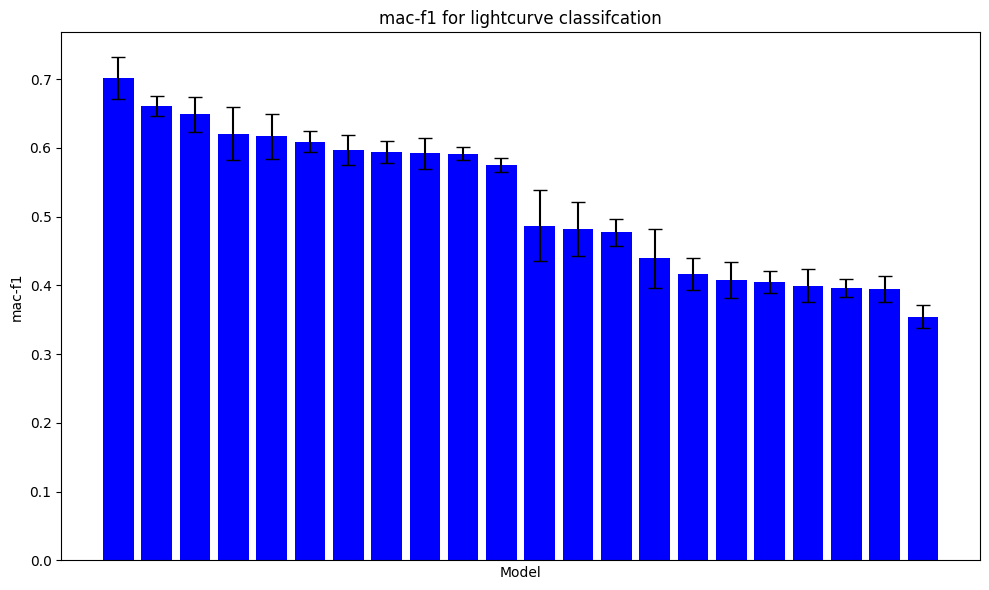

In [64]:
# Leaderboard in different metrics for classifications
# ========================
variable_name = "mac-f1"  # Choose from ['mic-f1', 'mic-p', 'mic-r', 'mic-acc', 'mac-f1', 'mac-p', 'mac-r', 'mac-acc']
modality = "lightcurve"
# ========================

lc_class_mean = class_mean[
    class_mean["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_std = class_std[
    class_std["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_mean = lc_class_mean.sort_values(by=variable_name, ascending=False)
lc_class_std = lc_class_std.loc[lc_class_mean.index]
plt.figure(figsize=(10, 6), dpi=100)
plt.bar(
    lc_class_mean["Model"],
    lc_class_mean[variable_name],
    yerr=lc_class_std[variable_name],
    capsize=5,
    color="blue",
)
# plt.ylim([0.7, 0.95])
plt.xlabel("Model")
plt.xticks([])
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

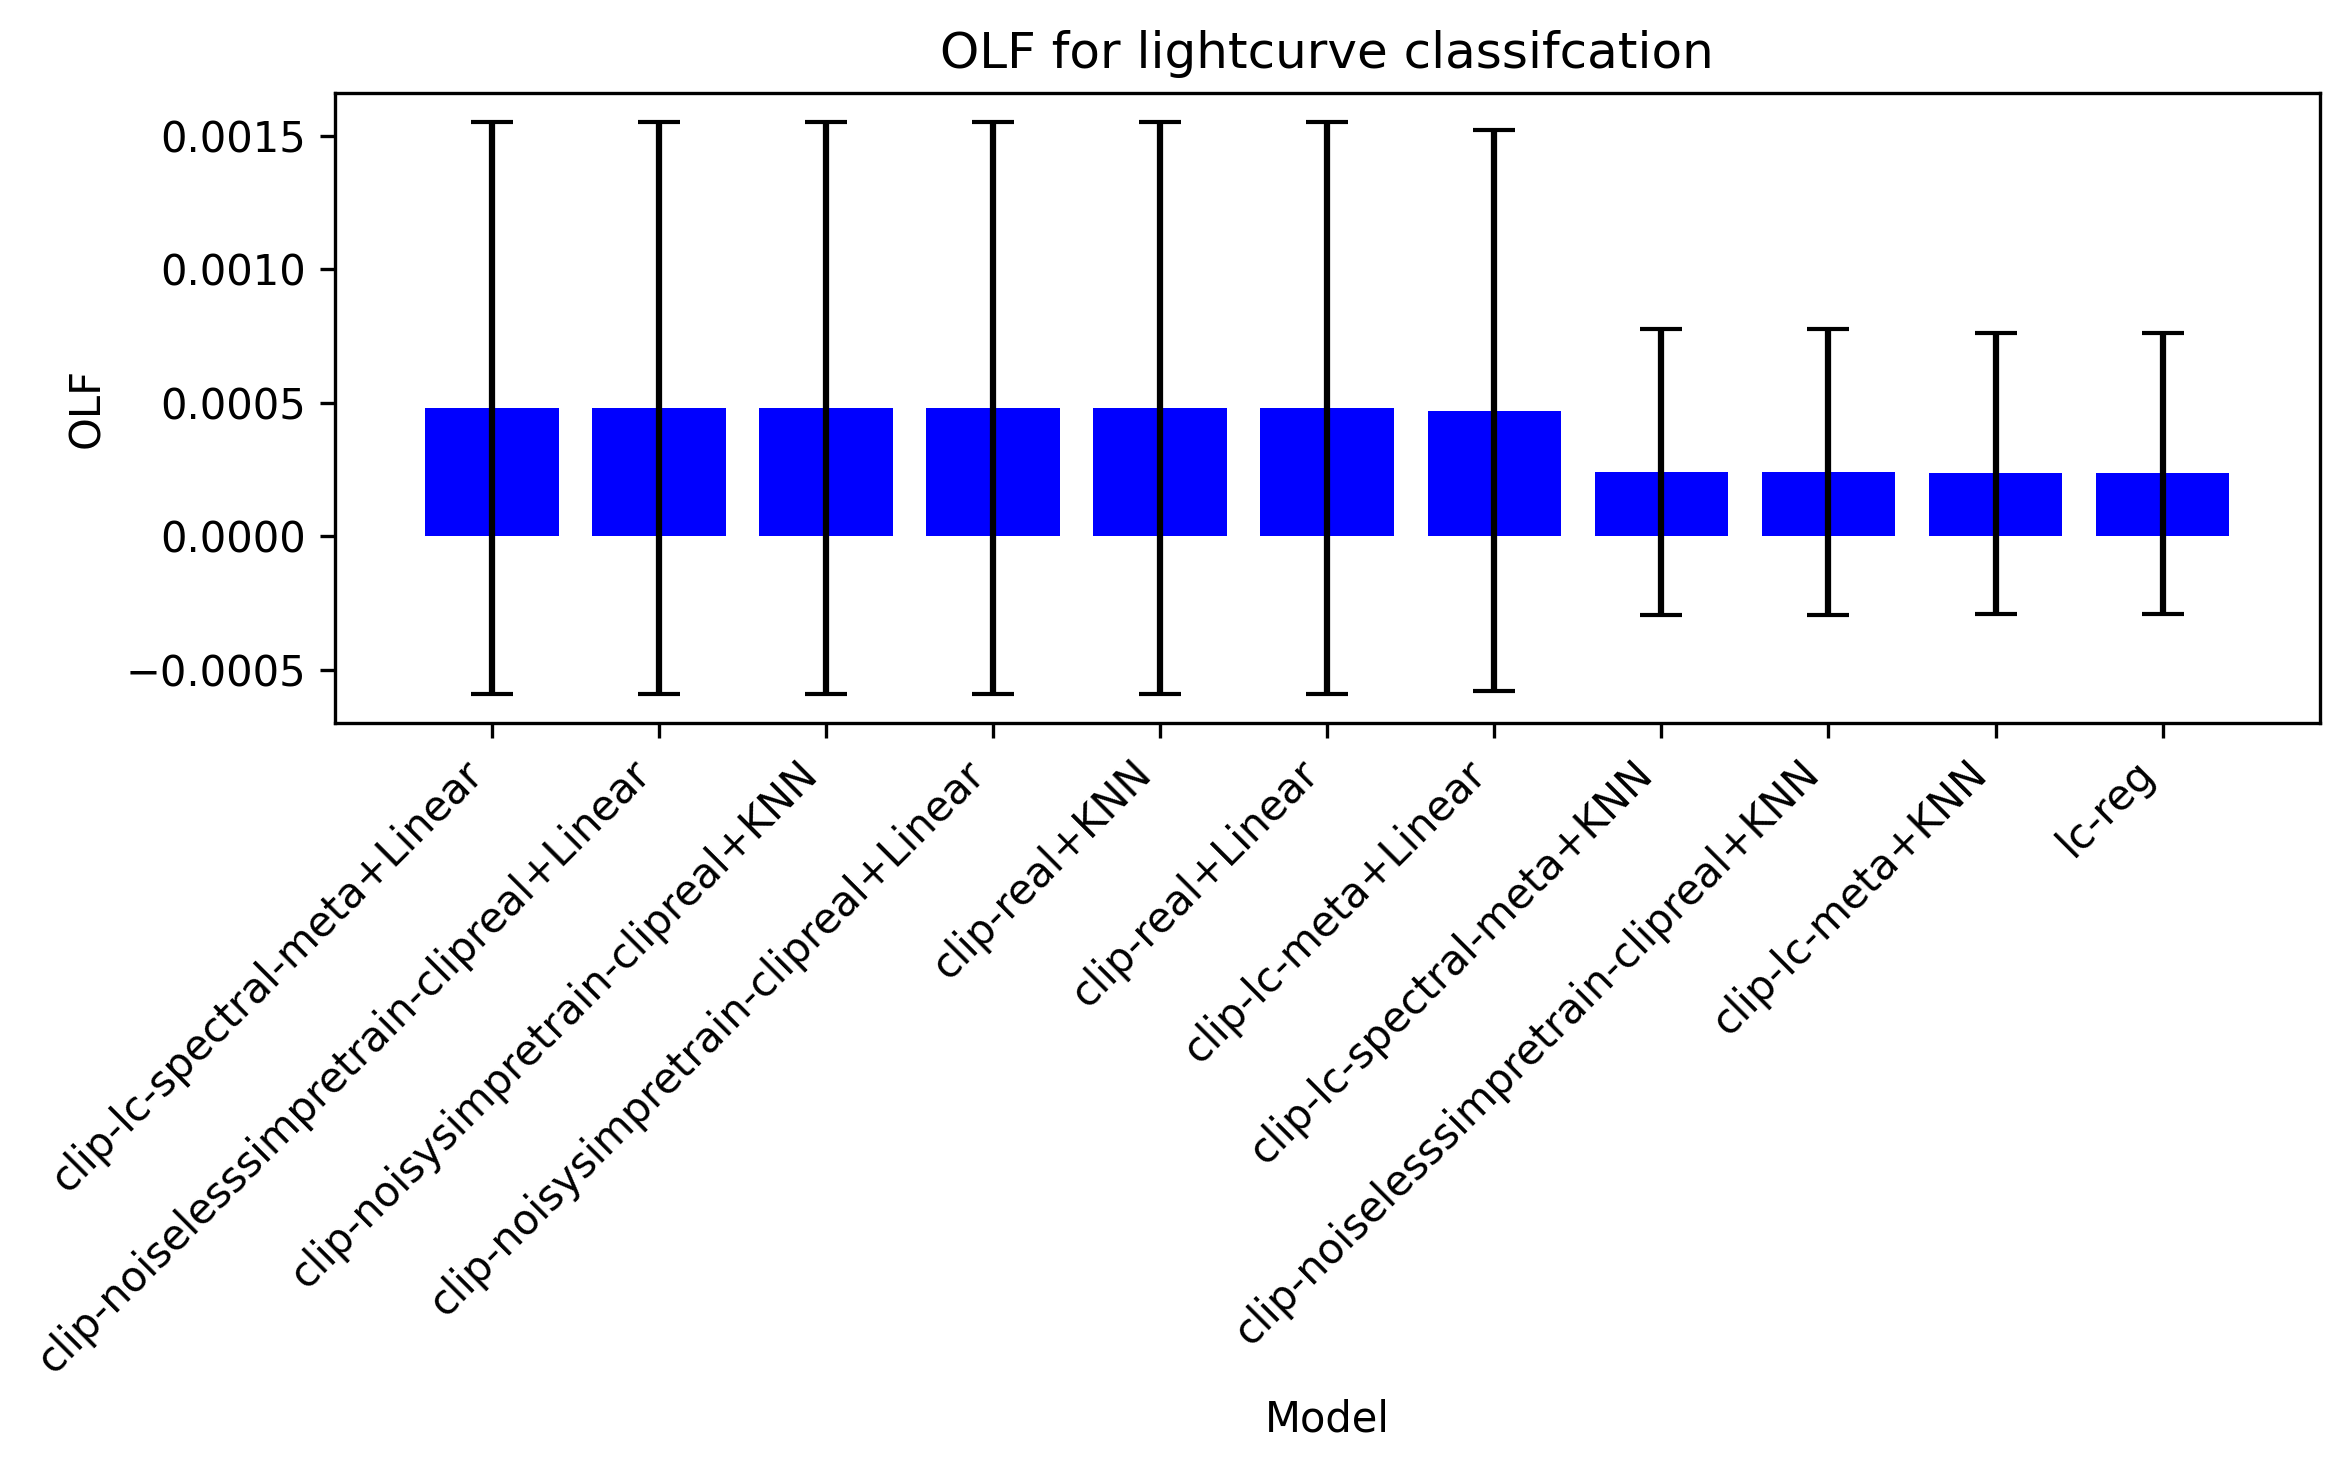

In [67]:
# ========================
variable_name = "OLF"  # Choose [ L1	L2	R2	OLF]
modality = "lightcurve"
# ========================

lc_reg_mean = reg_mean[reg_mean["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_std = reg_std[reg_std["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_mean = lc_reg_mean.sort_values(by=variable_name, ascending=False)
lc_reg_std = lc_reg_std.loc[lc_reg_mean.index]
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(
    lc_reg_mean["Model"],
    lc_reg_mean[variable_name],
    yerr=lc_reg_std[variable_name],
    capsize=5,
    color="blue",
)
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

### Classification results analysis - Analysis of redshift of rightly classified SN

In [68]:
def filter_elements(df, target_class):
    """
    Filters the DataFrame to include only rows where the specified target class is present.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing model predictions and true labels.
    target_class (float): The target class to filter for.

    Returns:
    pd.DataFrame: A DataFrame containing the filtered cases for the specified target class.
    """
    # Ensure the original 'y_pred' is kept intact for reference
    df["y_pred_all"] = df["y_true"]

    # Function to apply the mask within the arrays
    def filter_arrays(row):
        indices_pos_class = [
            i
            for i, (pred, true_label) in enumerate(
                zip(row["y_pred"], row["y_true_label"])
            )
            if pred == target_class and true_label == target_class
        ]
        indices_all = [
            i
            for i, true_label in enumerate(row["y_true_label"])
            if true_label == target_class
        ]
        indices_neg_class = [
            i
            for i, (pred, true_label) in enumerate(
                zip(row["y_pred"], row["y_true_label"])
            )
            if pred != target_class and true_label == target_class
        ]
        filtered_lc_data_all = (
            {
                key: [row["lc_data"][key][i] for i in indices_all]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )
        filtered_lc_data_pos = (
            {
                key: [row["lc_data"][key][i] for i in indices_pos_class]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )
        filtered_lc_data_neg = (
            {
                key: [row["lc_data"][key][i] for i in indices_neg_class]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )

        return {
            "y_pred": [row["y_pred"][i] for i in indices_pos_class],
            "y_true": [row["y_true"][i] for i in indices_pos_class],
            "y_true_label": [row["y_true_label"][i] for i in indices_pos_class],
            "y_pred_all": [row["y_pred_all"][i] for i in indices_all],
            "lc_data_all": filtered_lc_data_all,
            "lc_data": filtered_lc_data_pos,
            "lc_data_not": filtered_lc_data_neg,
        }

    # Apply the function to each row in the DataFrame
    filtered_data = df.apply(filter_arrays, axis=1)

    # Create a new DataFrame from the filtered data
    result_df = pd.DataFrame(filtered_data.tolist(), index=df.index)

    # Handle the lc_data separately to avoid column overlap
    lc_data_filtered = result_df.pop("lc_data")

    # Combine the filtered arrays back with the original DataFrame
    final_df = df.drop(columns=["y_pred", "y_true", "y_true_label", "y_pred_all"]).join(
        result_df
    )

    # Add the lc_data back to the final DataFrame
    final_df["lc_data"] = lc_data_filtered

    return final_df.reset_index(drop=True)

Filter out the models you want to compare the redshift distribtion

In [69]:
class_filter = 4.0
remove_models = ["three", "3way", "Linear", "noisy", "5way", "clip-real"]
"""
remove_models = [
    "three",
    "3way",
    "Linear",
]  
"""
lc_merged_classification = merged_classification[
    merged_classification["Combination"] == "lightcurve"
]

# Create a regex pattern from the list of strings
pattern = "|".join(remove_models)

if "three" in remove_models:
    class_names = {
        0: ("SLSN-I", "blue"),
        1: ("SN II", "green"),
        2: ("SN IIn", "teal"),
        3: ("SN Ia", "purple"),
        4: ("SN Ibc", "orange"),
    }
else:
    class_names = {
        0: ("SN II", "green"),
        1: ("SN Ia", "purple"),
        2: ("SN Ibc", "orange"),
    }

# Remove rows where the 'Model' column contains any of the strings in remove_models
df_cleaned = lc_merged_classification[
    ~lc_merged_classification["Model"].str.contains(pattern)
].reset_index()
print("We will work with these models: ")
print(df_cleaned[["Model", "Combination"]])
print(f"and we will remove class {class_names[int(class_filter)][0]}")

We will work with these models: 
                                         Model Combination
0                        clip-lc-meta+KNN+five  lightcurve
1               clip-lc-spectral-meta+KNN+five  lightcurve
2  clip-noiselesssimpretrain-clipreal+KNN+five  lightcurve
and we will remove class SN Ibc


<Figure size 1000x600 with 0 Axes>

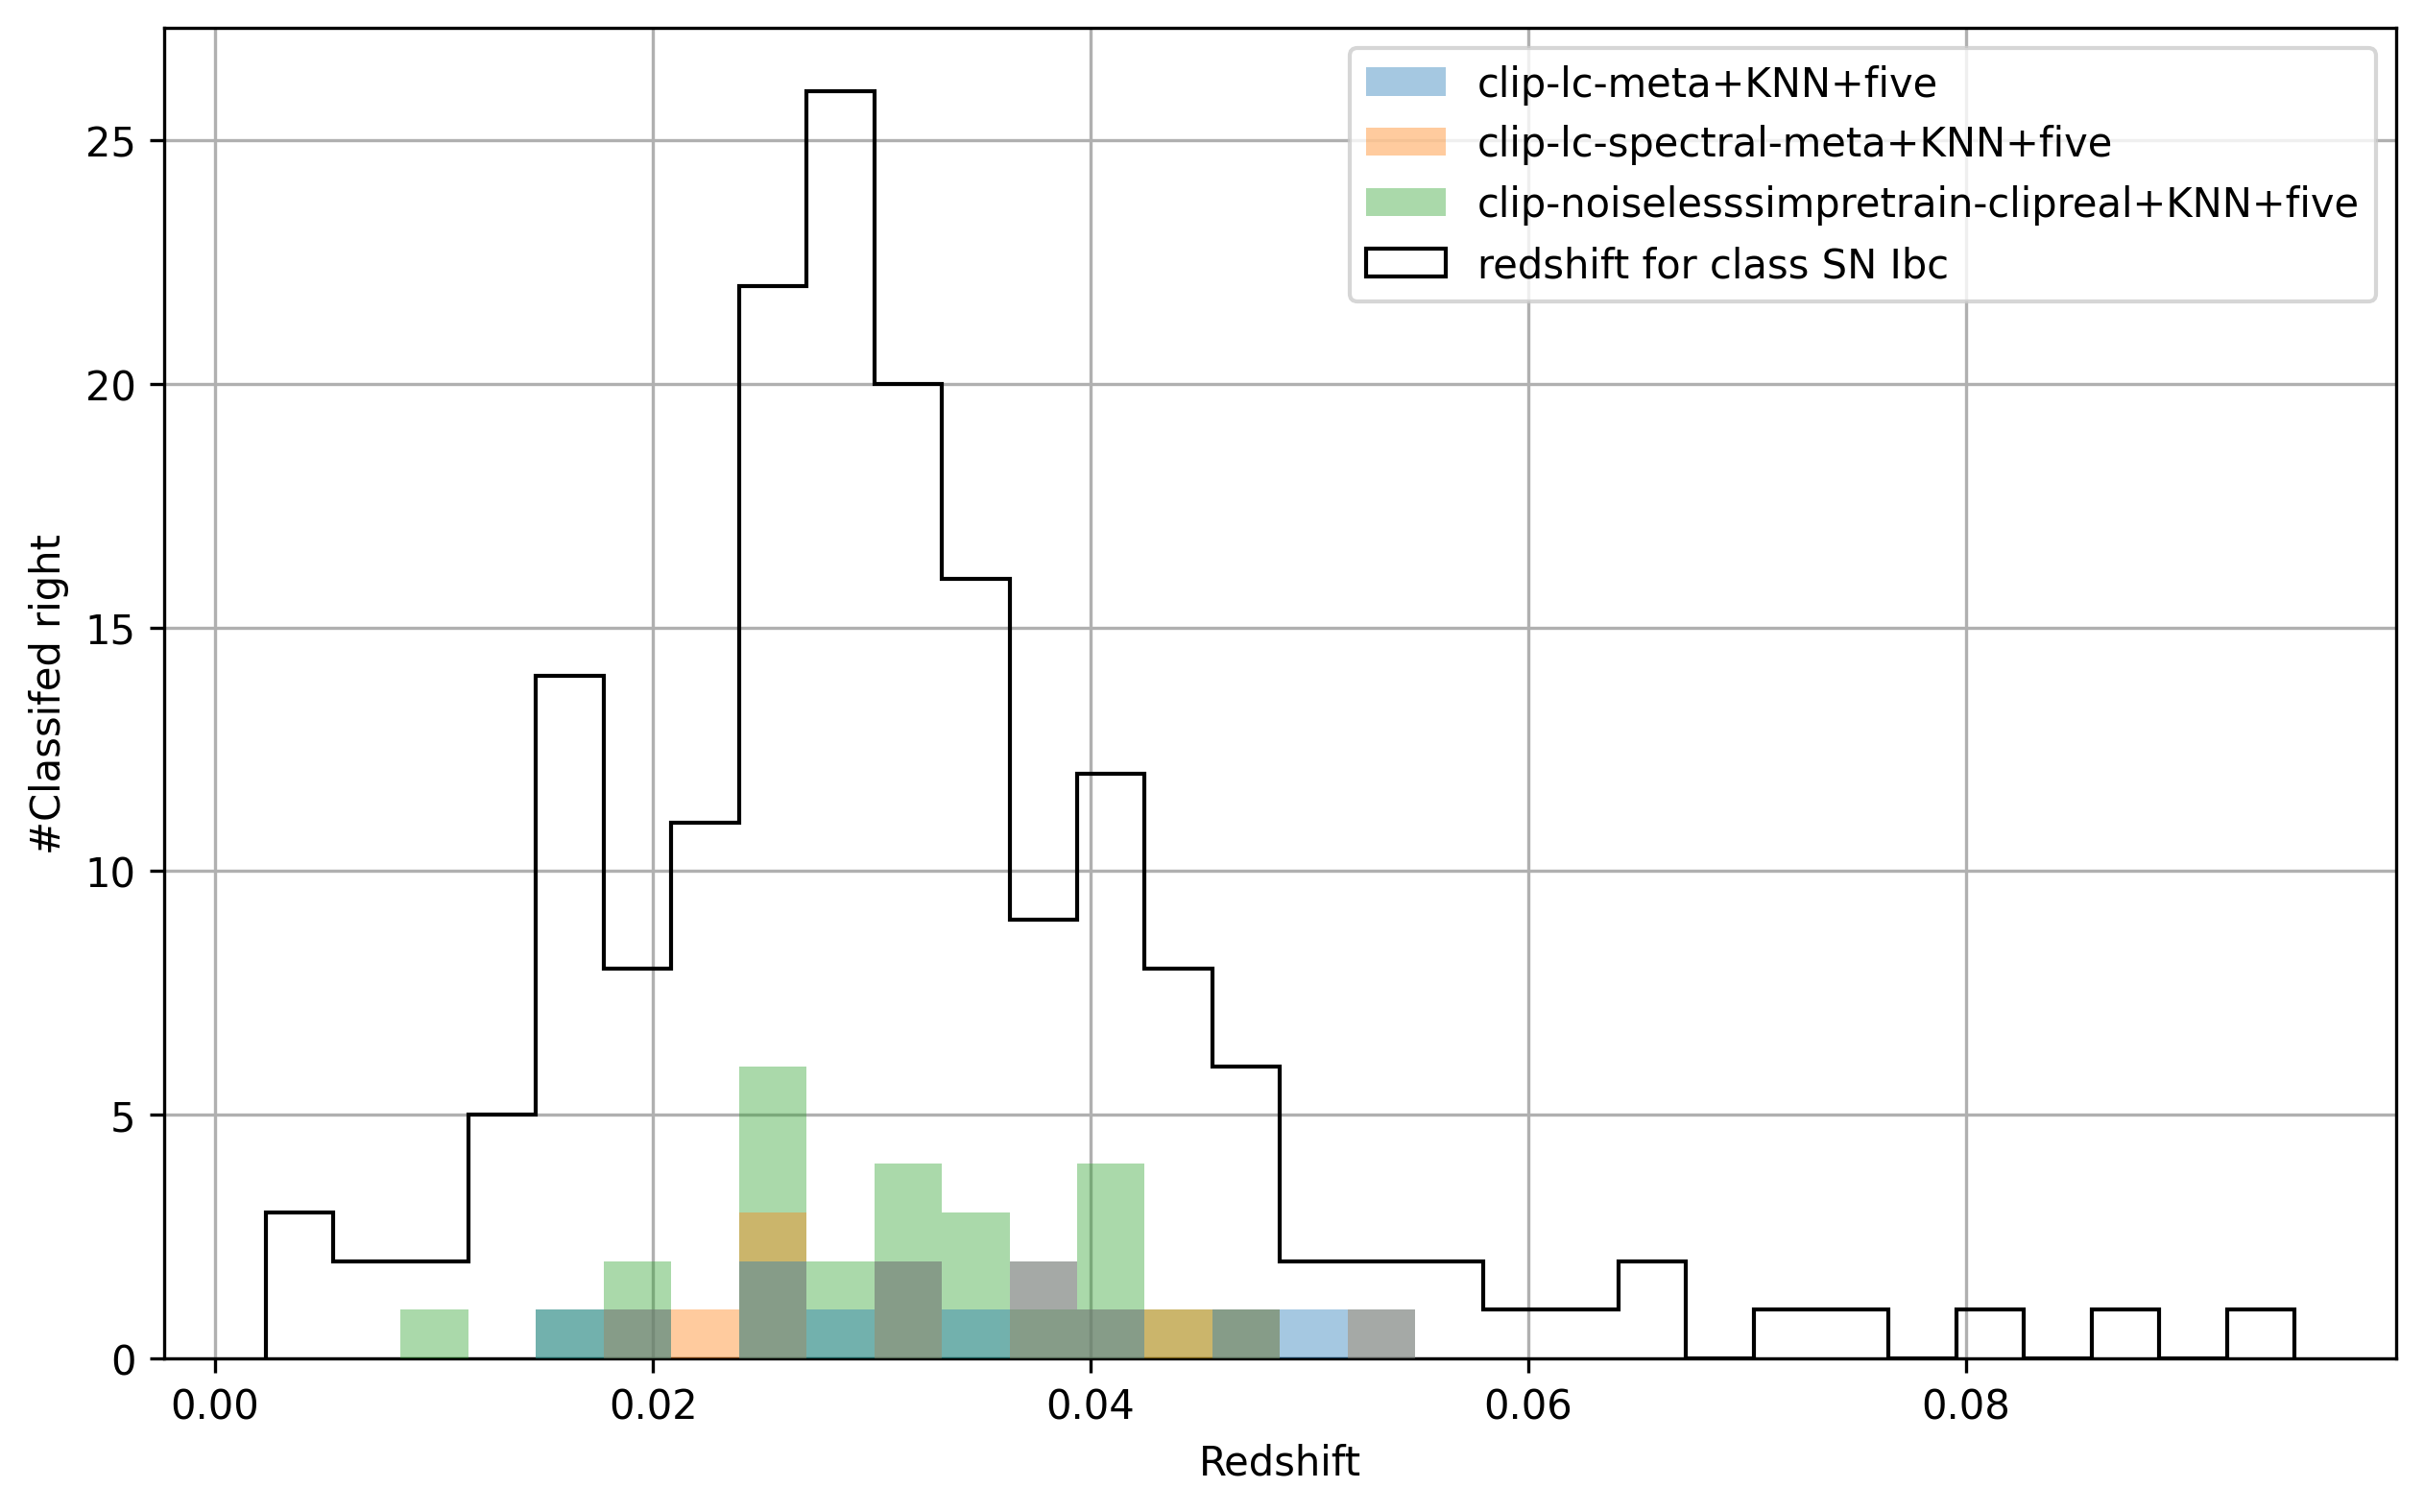

In [70]:
# Filter out classes
filtered_classified = filter_elements(df_cleaned, class_filter)

plt.figure(figsize=(10, 6))

# Determine the number of subplots needed
fig = plt.figure(figsize=(10, 6), dpi=300)
total_class_hist = filtered_classified["y_pred_all"][0]

for i, (index, row) in enumerate(filtered_classified.iterrows()):
    plt.hist(
        row["y_true"],
        bins=30,
        label=row["Model"],
        range=[min(total_class_hist), max(total_class_hist)],
        alpha=0.4,
        zorder=20 - i,
    )
plt.hist(
    total_class_hist,
    color="black",
    edgecolor="black",
    bins=30,
    range=[min(total_class_hist), max(total_class_hist)],
    label=f"redshift for class {class_names[int(class_filter)][0]}",
    histtype="step",
)
plt.xlabel("Redshift")
plt.ylabel("#Classifed right")
plt.legend()
plt.grid(True)

plt.savefig("redshiftmissclass.pdf")
plt.show()

In [71]:
def compute_masked_min(filtered_df, data="lc_data"):
    """
    Computes the minimum of x_lc after applying mask_lc for each batch.

    Parameters:
    filtered_df (pd.DataFrame): The filtered DataFrame containing 'lc_data' with 'x_lc' and 'mask_lc'.

    Returns:
    List: A list containing the masked minimum values for each batch.
    """
    x_lc_list = filtered_df[data].apply(lambda d: d["x_lc"] if d is not None else None)
    mask_lc_list = filtered_df[data].apply(
        lambda d: d["mask_lc"] if d is not None else None
    )
    masked_min_list = []

    for x_lc, mask_lc in zip(x_lc_list, mask_lc_list):
        if x_lc is not None and len(x_lc) > 0:
            masked_min = np.min(np.where(mask_lc, x_lc, np.inf), axis=1)
            masked_min_list.append(masked_min)
        else:
            masked_min_list.append([])

    return masked_min_list

In [72]:
# Filter out classes
filtered_classified = filter_elements(df_cleaned, class_filter)
min_lc_data_hit = compute_masked_min(filtered_classified, "lc_data")
min_lc_data_class_all = compute_masked_min(filtered_classified, "lc_data_all")
min_lc_data_miss = compute_masked_min(filtered_classified, "lc_data_not")

In [73]:
filtered_classified["Model"]

0                          clip-lc-meta+KNN+five
1                 clip-lc-spectral-meta+KNN+five
2    clip-noiselesssimpretrain-clipreal+KNN+five
Name: Model, dtype: object

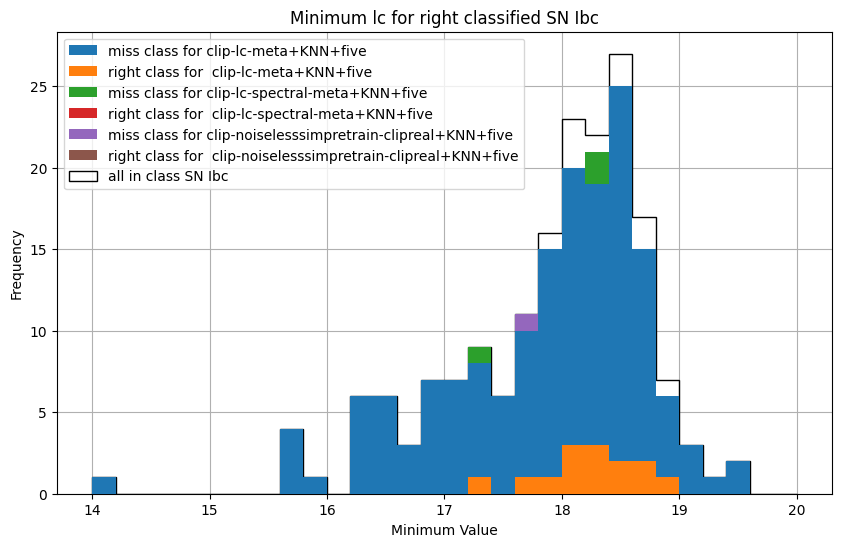

In [74]:
# Plot the masked minimum values
plt.figure(figsize=(10, 6))
for i, (hit, miss) in enumerate(zip(min_lc_data_hit, min_lc_data_miss)):
    if hit is not None:
        plt.hist(
            miss,
            bins=30,
            alpha=1,
            label=f'miss class for {filtered_classified["Model"][i]}',
            range=(14, 20),
            zorder=10 - i,
        )
        plt.hist(
            hit,
            bins=30,
            alpha=1,
            label=f'right class for  {filtered_classified["Model"][i]}',
            range=(14, 20),
            zorder=10 - i,
        )

plt.hist(
    min_lc_data_class_all[0],
    bins=30,
    label=f"all in class {class_names[int(class_filter)][0]}",
    range=(14, 20),
    histtype="step",
    edgecolor="black",
)

plt.title(f"Minimum lc for right classified {class_names[int(class_filter)][0]}")
plt.xlabel("Minimum Value")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

### Plot confusion plots

In [75]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns


def plot_cm(df_class, modelname, modality, normalisation):
    df_class_filter = df_class[df_class["Model"] == modelname].reset_index()
    df_class_filter = df_class_filter[
        df_class_filter["Combination"] == modality
    ].reset_index()

    if "five" in modelname or "5way" in modelname:
        class_names = {
            0: ("SLSN-I", "blue"),
            1: ("SN II", "green"),
            2: ("SN IIn", "teal"),
            3: ("SN Ia", "purple"),
            4: ("SN Ibc", "orange"),
        }
    else:
        class_names = {
            0: ("SN II", "green"),
            1: ("SN Ia", "purple"),
            2: ("SN Ibc", "orange"),
        }

    cm = confusion_matrix(
        df_class_filter["y_true_label"][0], df_class_filter["y_pred"][0]
    )
    if normalisation == "recall":
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        formats = ".2f"
    elif normalisation == "precision":
        cm = cm.astype("float") / cm.sum(axis=0, keepdims=True)
        formats = ".2f"
    else:
        formats = "d"

    # Create the plot
    plt.figure(figsize=(5, 4), dpi=100)
    sns.heatmap(
        cm,
        annot=True,
        fmt=formats,
        cmap="Blues",
        xticklabels=[class_names[label][0] for label in sorted(class_names)],
        yticklabels=[class_names[label][0] for label in sorted(class_names)],
    )
    plt.title(
        f'Normalized Confusion Matrix: {df_class_filter["Model"][0]}, {df_class_filter["Combination"][0]}'
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

In [76]:
print(f'available models: \n {merged_classification["Model"]}')

available models: 
 0      clip-lc-meta+KNN+five
1      clip-lc-meta+KNN+five
2      clip-lc-meta+KNN+five
3     clip-lc-meta+KNN+three
4     clip-lc-meta+KNN+three
               ...          
71    clip-real+Linear+three
72                lc-3way-f1
73                lc-5way-f1
74                sp-3way-f1
75                sp-5way-f1
Name: Model, Length: 76, dtype: object


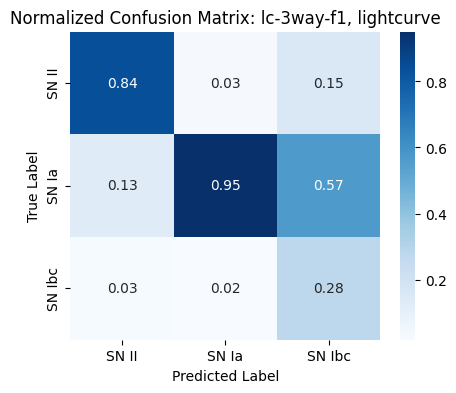

In [22]:
plot_cm(
    merged_classification,
    modelname="lc-3way-f1",
    modality="lightcurve",
    normalisation="precision",  # "recall" / "precision"
)

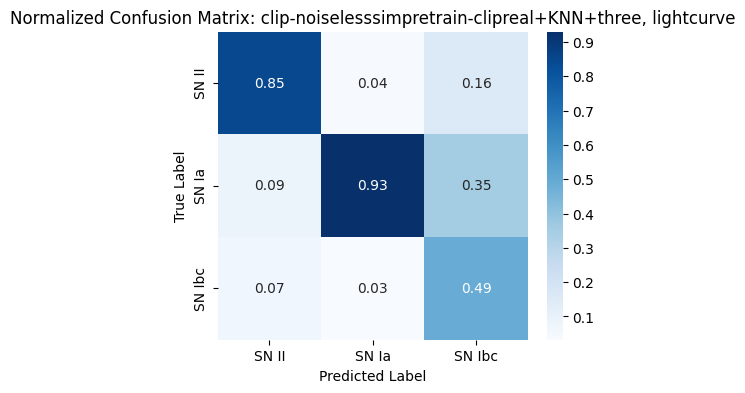

In [23]:
plot_cm(
    merged_classification,
    modelname="clip-noiselesssimpretrain-clipreal+KNN+three",
    modality="lightcurve",
    normalisation="precision",  # "recall" / "precision"
)